### Notas
- El dataset final tiene 16424 casos de los cuales son 3488 positivos.

- Tengo que agregar un detector de voz y separar en frames los audios.
- Si se separan los audios en frames, es necesario hacer una separación de hablantes?. Qué pasaría si en un mismo frame coinciden ambos hablantes a la vez?
- Podría hacer detectores para todas las emociones, de esa forma el dataset va a estar mas equilibrado.
- En ¨Speech Emotion Recognition Based on Multi-feature and Multi-lingual Fusion¨ combinaron datasets en inglés y en chino. Sería interesante probar combinar datasets en distintos idiomas, primeramente combinar los que tengo en inglés con alguno en español ya que la idea es reconocer emociones en español. Pero luego se podrían probar otros idiomas también. Esto además ayudaría a ampliar el dataset.
- En "Speech Emotion Recognition based on Gaussian Mixture Models and Deep Neural Networks" Usan un modelo mixto de gauss para cada feature que quieren analizar. Luego,los resultados de cada uno de los modelos se usan como features para una red neuronal que hace la clasificación final. Esto tiene dos ventajas, primero, permite features de diferentes dimensiones, ya que las salidas de todos los GMM van a ser de la misma dimensión (Un vector con la probabilidad de pertenecer a la distribución o al UBM). Segundo, la red neuronal aprende los distintos pesos de cada feauture.
![title](Imagenes/Diagrama_GMM-DNN.jpg)

Tengo dudas en este caso de cómo están entrenados los modelos mixtos de gauss:

¨The problem we address here is that different features (each
of the Mel filters, pitch, their deltas) may carry more or less
information about the emotion. During the training phase we
create one GMM-signature for each of the emotions in the
same way as above+. During the evaluation phase the log-
likelihood distance between the voice query and each of the
emotions is computed for each one of the features and deltas
separately. This new vector of features is the input of an ELM,
which produces the final classification. During the training
phase ELM learns the different weights and dependencies
of the distances between low-level features and each of the
emotions...¨
+ con ¨above¨ se refiere al método clásico de detectar emociones con GMM, o sea, entrenando cada GMM para detectar esa emoción, o sea, cada GMM se entrena usando un solo feature y se los entrena para detectar la discusión. Luego, se calcula el log-likelihood distance para cada feature y se forma un nuevo vector que contiene información de todos los features.

Una posibilidad:
- Entrenar un GMM cuya entrada sea un solo feature, entrenar un UBM para este feature. Con la salida de ambos se arma un vector (P(GMM), P(UBM)) con la probabilidad de que el audio pertenezca al GMM y al UBM.
- Al momento de entrenar la red neuronal se usan estos vectores, se arma una matriz juntando este vector para cada feature, si se tienen 5 features, se va a tener una matriz de 5x2.
- Esto me suena raro, es un proceso un poco largo, el entrenamiento implica entrenar muchos GMM, y luego, para la predicción también trendría que calcular la probabilidad para varios GMM, además de calcular todas las features.

¨For training of the ELM was used the evaluation set.¨ Y con qué se validó el ELM entonces?. Sobre como se hizo con el método que usa DNN no dice nada. Debería tener dos trining sets? 1 para entrenar los GMM, y otro para entrenar las DNN?

#### Imports

In [1]:
import os
import glob
import numpy as np
# import keras
import librosa
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.signal import lfilter, butter
from scipy.io.wavfile import read,write
import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras import callbacks
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#### Modelo de Redes convolucionales con distintas métricas.

- 1 Mètrica: Balanced Accuracy
- 2 Métrica: Average precision
- 3 Métrica: Recall
- 4 Métrica: F1-score
- 5 Métrica: Cohen's KAPPA
- 6 Métrica: Accuracy


In [2]:
def create_model_CNN(metric):
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = Sequential([
        Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = 'same', input_shape =(1 ,120)),
        Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = 'same'),
        # Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = 'same', input_shape =(1 ,120), kernel_regularizer=keras.regularizers.l2(0.01)),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Flatten(),
        Dense(units = 128, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 64, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 1, activation = 'sigmoid')])
        
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metric])
    
    return model


#### Datasets

In [3]:

meld = np.load('Meld.npy', allow_pickle=True)
Meld_X = meld[()]['x']
Meld_Y = meld[()]['y']
enterface = np.load('Enterface.npy', allow_pickle=True)
Enterface_X = enterface[()]['x']
Enterface_Y = enterface[()]['y']
full_X = np.concatenate((Enterface_X, Meld_X), axis=0)
full_Y = np.concatenate((Enterface_Y, Meld_Y), axis=0)

#### Modelo 1 Balanced Accuracy

In [4]:
model_1 = create_model_CNN(keras.metrics.Recall())
model_1.build()
model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             53824     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 256)            9

 Modelo 1 con dataset completo

In [5]:
X = Meld_X
Y = Meld_Y
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.1, random_state=9)
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

print(x_train.shape, x_test.shape, y_test.shape, y_train.shape)
history = model_1.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, callbacks=[earlystopping])
model_1.save_weights('./model_1')


(14745, 1, 120) (1639, 1, 120) (1639,) (14745,)
Epoch 1/100
461/461 [==============================] - 8s 11ms/step - loss: 0.6221 - recall: 0.0160 - val_loss: 0.3971 - val_recall: 0.6996
Epoch 2/100
461/461 [==============================] - 4s 9ms/step - loss: 0.3882 - recall: 0.6670 - val_loss: 0.3313 - val_recall: 0.6659
Epoch 3/100
461/461 [==============================] - 5s 10ms/step - loss: 0.3425 - recall: 0.6802 - val_loss: 0.3263 - val_recall: 0.6592
Epoch 4/100
461/461 [==============================] - 5s 11ms/step - loss: 0.3393 - recall: 0.6716 - val_loss: 0.3180 - val_recall: 0.6413
Epoch 5/100
461/461 [==============================] - 5s 10ms/step - loss: 0.3217 - recall: 0.6775 - val_loss: 0.3111 - val_recall: 0.6525
Epoch 6/100
461/461 [==============================] - 6s 13ms/step - loss: 0.3067 - recall: 0.6855 - val_loss: 0.3147 - val_recall: 0.6614
Epoch 7/100
461/461 [==============================] - 5s 10ms/step - loss: 0.3035 - recall: 0.6784 - val_loss: 0

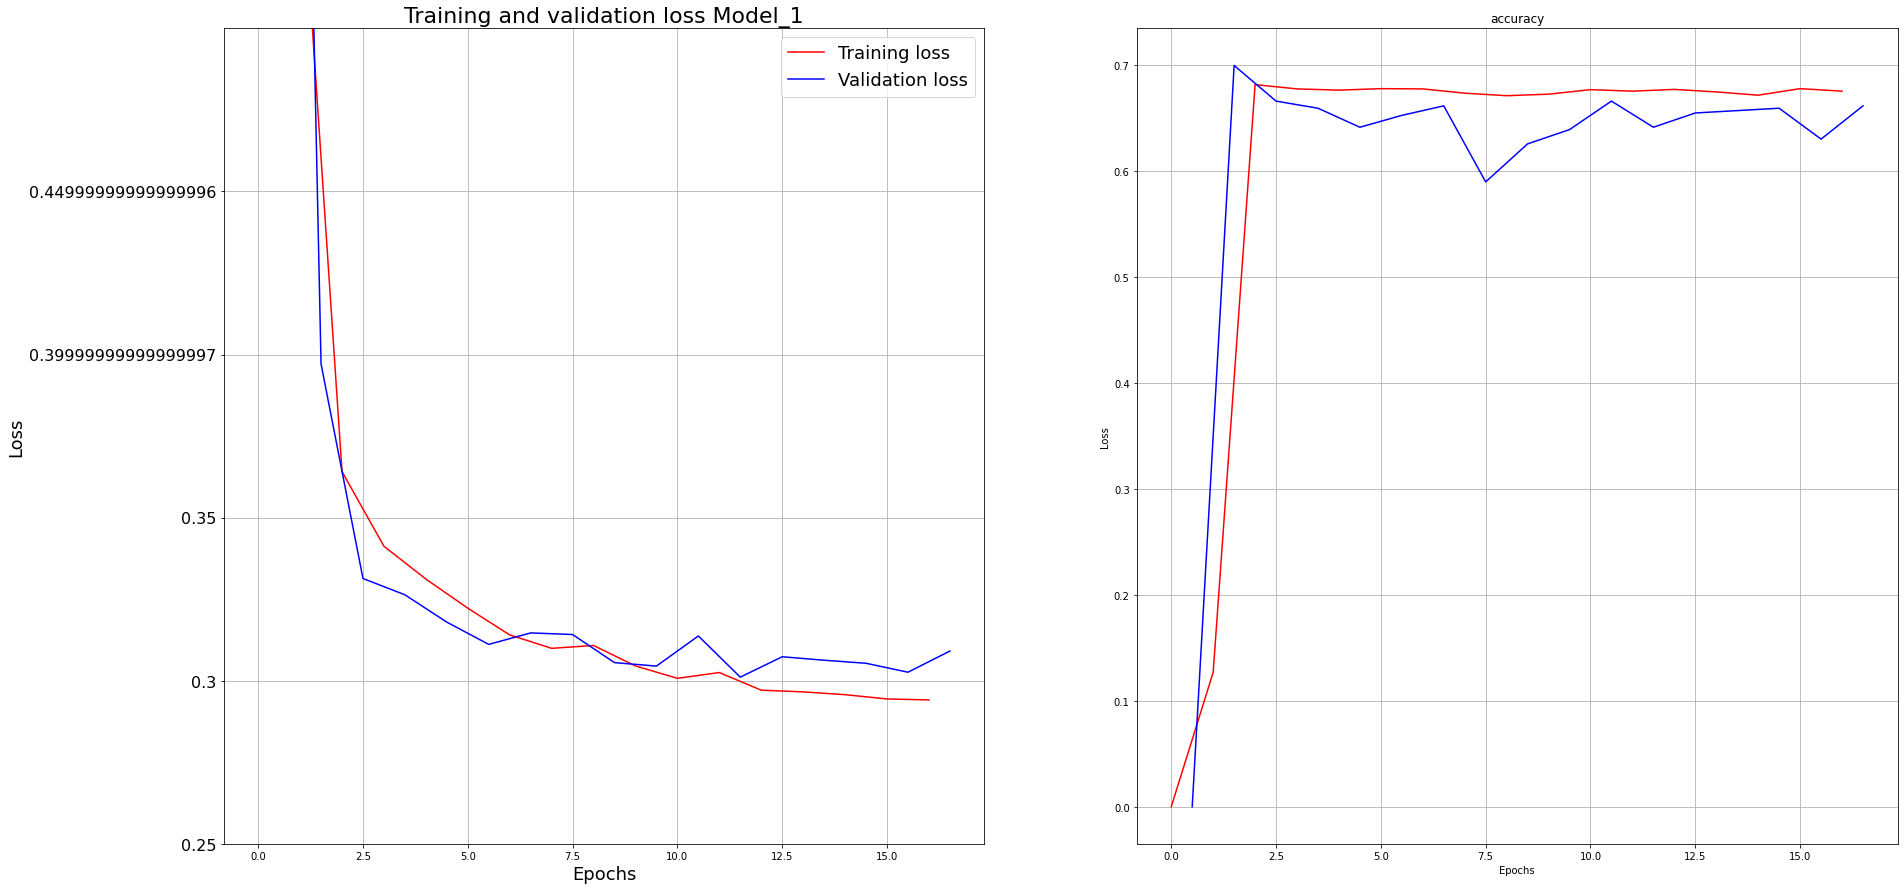

In [6]:
loss = [1]
loss.extend(history.history['loss'])


val_loss = [1]
val_loss.extend(history.history['val_loss'])

epochs = list(range(0, len(loss)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

ax1.plot(epochs, loss, 'r', label='Training loss')
ax1.plot([epoch+0.5 for epoch in epochs], val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss Model_1', fontsize=22)
ax1.set_xlabel('Epochs', fontsize=18)
ax1.set_ylabel('Loss', fontsize=18)

ax1.legend(fontsize=18)
Min = min(loss) - 0.05
ticks = np.arange(0.25, 0.5, 0.05)
ax1.set_yticks(ticks)
ax1.set_ylim((0.25,0.5))

# ax1.set_xticklabels(range(0, len(epochs),5), fontsize=16)
ax1.set_yticklabels(ticks, fontsize=16)
ax1.grid()

accuracy = [0]
accuracy.extend(history.history['recall'])
val_accuracy = [0]
val_accuracy.extend(history.history['val_recall'])


ax2.plot(epochs, accuracy, 'r', label='Training accuracy')
ax2.plot([epoch+0.5 for epoch in epochs], val_accuracy, 'b', label='Validation accuracy')
ax2.set_title('accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.grid()

# ax2.legend()

plt.show()


In [10]:
y_pred = model_1.predict(x_test)
threshold = 0.5
y_pred_binary = []
for pred in y_pred:
    if pred > threshold:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)



# y_pred_conf= []
# y_test_conf= []
# for y in zip(y_pred,y_test):
#     y_pred_conf.append(int(round(y[0][0])))
#     y_test_conf.append(y[1][0])
# y_pred_roc = []
# y_test_roc = []
# for y in zip(y_pred,y_test):
#     y_pred_roc.append(y[0][0])
#     y_test_roc.append(y[1][0])

In [13]:

conf = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
accuracy = (tp + tn) / (fn + fp + tp + tn) #Exactitud, porcentaje de predicciones correctas
precision = tp / (fp + tp) #Precisión, porcentaje de predicciones positivas correctas
specifity = tn / (tn + fn) #Especificidad, porcentaje de casos negativos detectados correctamente
recall = tp / (tp + fn) # sensibilidad, porcentaje de casos positivos detectados
true_negative_rate = tn / (tn + fp)
F1_score = precision * 2 * recall / (precision + recall)
print('Exactitud: ', accuracy)
print('Precisión: ', precision)
print('Especificidad: ', specifity)
print('Sensibilidad: ', recall)
print(' true_negative_rate: ', true_negative_rate)
print('F1 - Score: ', F1_score)

Exactitud:  0.8956680902989628
Precisión:  0.9629629629629629
Especificidad:  0.8807749627421758
Sensibilidad:  0.6412556053811659
 true_negative_rate:  0.9907795473595976
F1 - Score:  0.7698519515477792


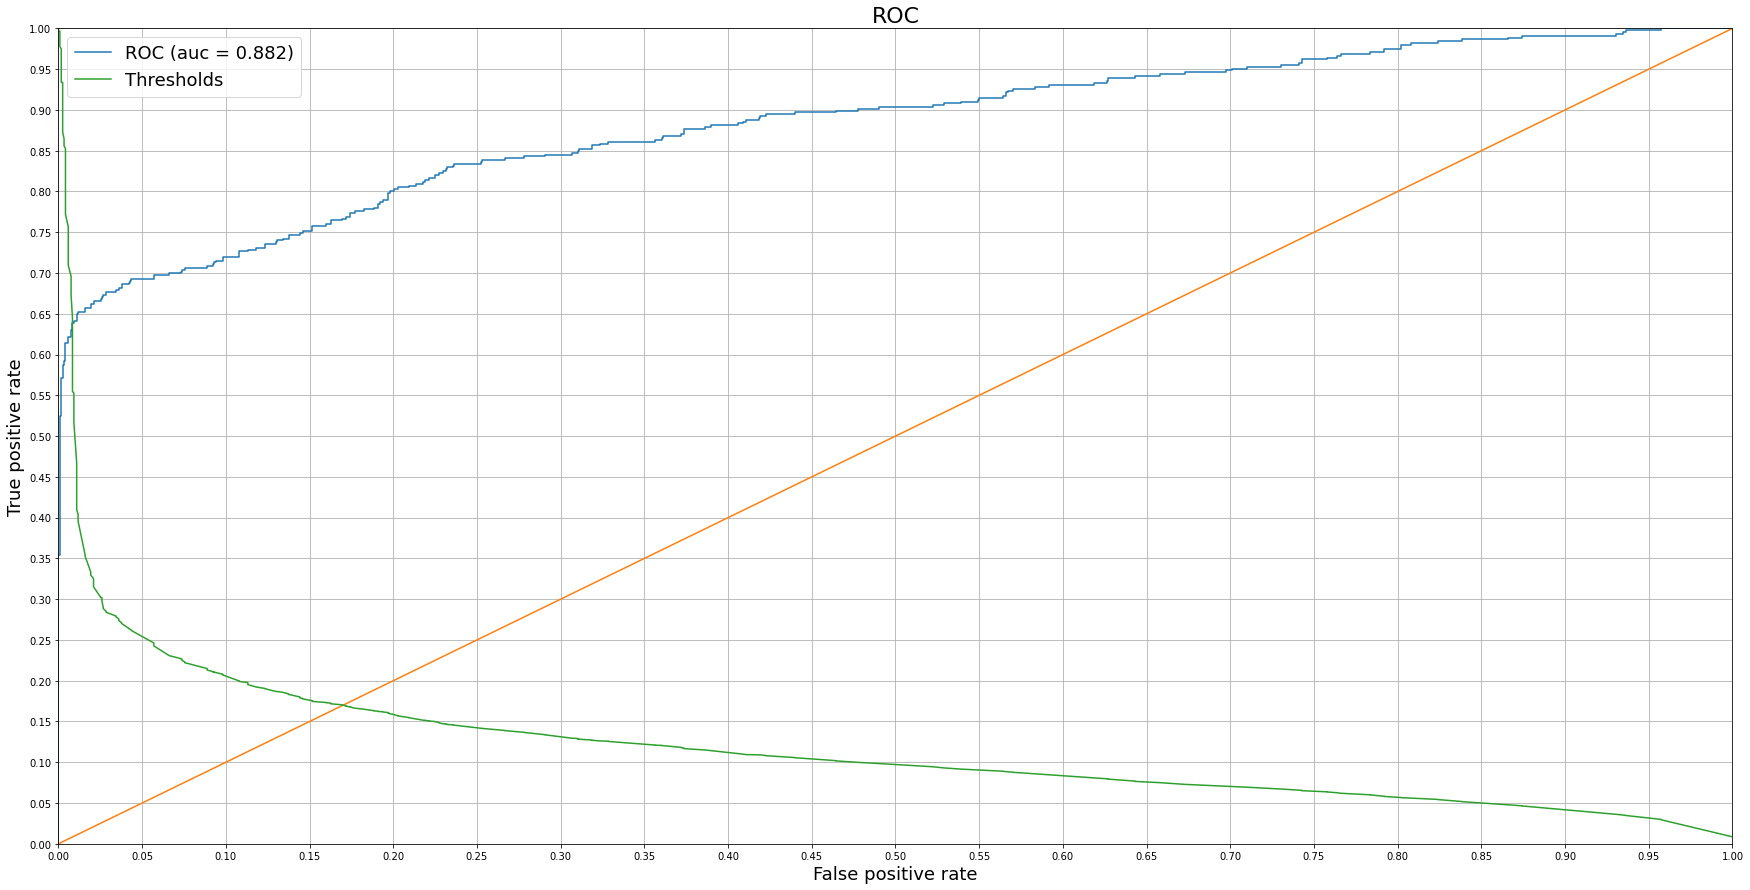

In [12]:



nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)

fig, ax1 = plt.subplots(1, 1, figsize=(30,15))

ax1.plot(nn_fpr_keras, nn_tpr_keras, label='ROC (auc = %0.3f)' % auc_keras)

ax1.set_title('ROC', fontsize=22)
ax1.set_xlabel('False positive rate', fontsize=18)
ax1.set_ylabel('True positive rate', fontsize=18)


ticks = np.arange(0, 1.05, 0.05)
ax1.set_yticks(ticks)
ax1.set_xticks(ticks)
ax1.set_ylim((0,1))
ax1.set_xlim((0,1))
ax1.plot(ticks, ticks)
ax1.plot(nn_fpr_keras, nn_thresholds_keras, label='Thresholds')
# ax1.set_xticklabels(range(0, len(epochs)), fontsize=16)
# ax1.set_yticklabels(ticks, fontsize=16)
ax1.legend(fontsize=18)
ax1.grid()


